## Assignment: Logistic regression algorithm on Amazon Fine Food Reviews for :
***1. BoW***

***2. Tf-Idf***

***3. AvgW2V***

***4. TF-idf-W2V Vectorizers***

In [1]:
#imporing general purpose libraries:
import time
import datetime
import os
import sys
import warnings
import pickle
import random
import psutil
warnings.filterwarnings('ignore')

#importing EDA libraries:
import math
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

***importing performance metric libraries***

In [2]:
#importing Logistic regression libraries:
from sklearn.linear_model import LogisticRegression

#train test split libaries:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#importing performance libraries:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

***Imporing preprocessed cleaned data from database file***

In [3]:
%%time
import sqlite3
con = sqlite3.connect('/home/jalesh_j/Data_Preprocessing/cleaned.sqlite')
df = pd.read_sql_query("""select * from cleandf""", con)

CPU times: user 2.51 s, sys: 1.36 s, total: 3.87 s
Wall time: 6.47 s


***feature engineered / non engineered columns for BoW and {tf-idf, avg-w2v, tfidf-w2v}***

In [4]:
df.columns

Index(['index', 'Score', 'Time', 'Text', 'Summary', 'cleanedtext',
       'numeric_score', 'bow_feat', 'bow_new_feat', 'tfw2v_feat'],
      dtype='object')

In [5]:
vectorizer = ['bow']
for i in vectorizer:
    print('unfeatured preprocesed column for vectorizer: {} is: \n {}'.format(i, df.cleanedtext.head(1)))
    print()
    print('featured preprocesed column for vectorizer: {} is: \n {}'.format(i, df.bow_new_feat.head(1)))

unfeatured preprocesed column for vectorizer: bow is: 
 0    bought sever vital can dog food product found ...
Name: cleanedtext, dtype: object

featured preprocesed column for vectorizer: bow is: 
 0    good qualiti dog food bought sever vital can d...
Name: bow_new_feat, dtype: object


In [6]:
vectorizer = ['tfidf', 'avg-w2v', 'tfidf-w2v']
for i in vectorizer:
    print('UNFEATURED COLUMN for vectorizer: {} is: \n {}'.format(i, df.Text.head(1)))
    print()
    print('FEATURED COLUMN for vectorizer: {} is: \n {}'.format(i, df.tfw2v_feat.head(1)))

UNFEATURED COLUMN for vectorizer: tfidf is: 
 0    i have bought several of the vitality canned d...
Name: Text, dtype: object

FEATURED COLUMN for vectorizer: tfidf is: 
 0    i have bought several of the vitality canned d...
Name: tfw2v_feat, dtype: object
UNFEATURED COLUMN for vectorizer: avg-w2v is: 
 0    i have bought several of the vitality canned d...
Name: Text, dtype: object

FEATURED COLUMN for vectorizer: avg-w2v is: 
 0    i have bought several of the vitality canned d...
Name: tfw2v_feat, dtype: object
UNFEATURED COLUMN for vectorizer: tfidf-w2v is: 
 0    i have bought several of the vitality canned d...
Name: Text, dtype: object

FEATURED COLUMN for vectorizer: tfidf-w2v is: 
 0    i have bought several of the vitality canned d...
Name: tfw2v_feat, dtype: object


In [7]:
for i in df.tfw2v_feat.head(1):
    print(i)
print('\n' * 2)    
for i in df.Text.head(1):
    print(i)

i have bought several of the vitality canned dog food products and have found them all to be of good quality  the product looks more like a stew than a processed meat and it smells better  my labrador is finicky and she appreciates this product better than  most  good quality dog food



i have bought several of the vitality canned dog food products and have found them all to be of good quality  the product looks more like a stew than a processed meat and it smells better  my labrador is finicky and she appreciates this product better than  most 


***sorting dataframe based on time***

In [4]:
#sorting the datframe based on time:
print(len(df))
df = df.sort_values('Time', ascending=True)
print()
df['Time'].head(8)

364171



117924    939340800
117901    940809600
298792    944092800
169281    944438400
298791    946857600
169342    947376000
169267    948240000
63317     948672000
Name: Time, dtype: int64

***taking out 1L datapoints, saving it into vectorizers seperately***

In [5]:
%%time
d = df.head(100000)
#bow
bow = d['cleanedtext']
bow_featured = d.bow_new_feat

#tfidf
tfidf = d.Text
tfidf_featured = d.tfw2v_feat

#w2v
w2v = d['Text']
w2v_featured = d['tfw2v_feat']

#class labels:
y = d['numeric_score'].apply(lambda x: 0 if int(x) < 3 else 1)
print(y.value_counts())

1    87729
0    12271
Name: numeric_score, dtype: int64
CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 53.3 ms


# 1. LR on BoW [L1 reg.]

***train, cv, test split***

In [10]:
xtrain, xtest, ytrain, ytest = train_test_split(bow, y, test_size=0.2, shuffle=False)
xtr, xcv, ytr, ycv = train_test_split(xtrain, ytrain, test_size=0.2, shuffle=False)

***BoW object instantiation***

In [11]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
bow_object = CountVectorizer(ngram_range=(1,1))
xtr = bow_object.fit_transform(xtr)
xcv = bow_object.transform(xcv)
xtest = bow_object.transform(xtest)
print(xtr.shape)
print(xcv.shape)
print(xtest.shape)

(64000, 31507)
(16000, 31507)
(20000, 31507)
CPU times: user 3.94 s, sys: 20 ms, total: 3.96 s
Wall time: 3.96 s


***column standardization***

In [12]:
sc = StandardScaler(with_mean=False)
xtr = sc.fit_transform(xtr)
xcv = sc.transform(xcv)
xtest = sc.transform(xtest)

/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


***Logistic regression on Bow***

In [13]:
%%time
from sklearn.linear_model import LogisticRegression

auc_cv_dict = {}
auc_tr_dict = {}

c_val = [10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 10**1, 10 ** 2, 10 ** 3, 10** 4]

for i in c_val:
    lr = LogisticRegression(penalty='l1', C=i, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='saga')
    lr.fit(xtr, ytr)
    y_pred_cv = lr.predict_proba(xcv)        
    fpr_cv, tpr_cv, thresholds_cv = roc_curve(ycv, y_pred_cv[:,1])
    auc_cv_dict[i] = auc(fpr_cv, tpr_cv)    
    #performance metrics for training data:
    y_pred_tr = lr.predict_proba(xtr)
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(ytr, y_pred_tr[:,1])
    auc_tr_dict[i] = auc(fpr_tr, tpr_tr)

/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reac

CPU times: user 3min 5s, sys: 52 ms, total: 3min 5s
Wall time: 3min 5s


/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


***optimal C value for AUC score on training and CV data***

In [14]:
#sorting dictionary wrt higest AuC Score of both training and cv data:

cv_tup = sorted(auc_cv_dict.items(), key= lambda x: x[1],reverse=True)
tr_tup = sorted(auc_tr_dict.items(), key= lambda x: x[1],reverse=True)
print(cv_tup)
print('*' * 70)
print(tr_tup)


[(0.01, 0.9262401372092973), (0.1, 0.9230231533978038), (10, 0.9225882000326433), (100, 0.922582898178632), (10000, 0.9225822606139091), (1000, 0.922582227057871), (0.001, 0.911956774722478), (0.0001, 0.6487500073823284)]
**********************************************************************
[(10000, 0.9610585593760395), (1000, 0.9610585546249237), (100, 0.9610583954625457), (10, 0.9610565116451475), (0.1, 0.9608155184249683), (0.01, 0.9571962039601828), (0.001, 0.9142371497718285), (0.0001, 0.6456716179730633)]


***Plotting AUC Curve on training and cv data***

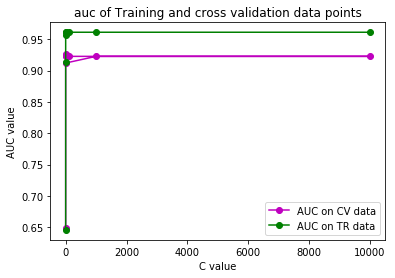

In [15]:
plt.plot([x[0] for x in cv_tup], [x[1] for x in cv_tup], linestyle='-', color='m', marker='o',label='AUC on CV data')
plt.plot([x[0] for x in tr_tup], [x[1] for x in tr_tup], linestyle='-', color='g', marker='o', label='AUC on TR data')
#plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("C value")
plt.ylabel('AUC value')
plt.title('auc of Training and cross validation data points')
plt.legend()

***optimal LR-BoW(L1) for C=0.01***

In [16]:
lr = LogisticRegression(penalty='l1', C=0.01, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='saga')
lr.fit(xtr, ytr)
y_pred_test = lr.predict_proba(xtest)
y_pred = lr.predict(xtest)
fpr_test, tpr_test, thresholds_test= roc_curve(ytest, y_pred_test[:,1])
auc_test = auc(fpr_test, tpr_test)
optimal_weight = lr.coef_
print(auc_test)

0.9285906774051154


/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


***plotting confusion matrix on test data***

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


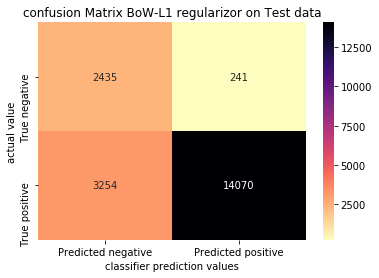

In [17]:
%time
y_pred_test = np.where(y_pred_test[:,1] < 0.5, 0, 1)
#creating confusion matrix:

cf = confusion_matrix(ytest, y_pred_test)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix BoW-L1 regularizor on Test data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

***plotting confusion matrix on train data***

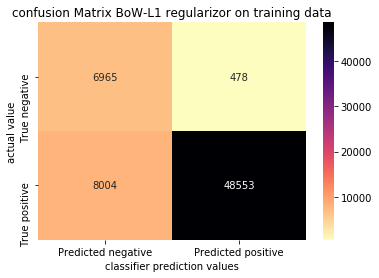

In [18]:
y_pred_tr = np.where(y_pred_tr[:,1] > 0.5, 1, 0)
#creating confusion matrix:

cf = confusion_matrix(ytr, y_pred_tr)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix BoW-L1 regularizor on training data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

***plotting ROC curve on test vs training data***

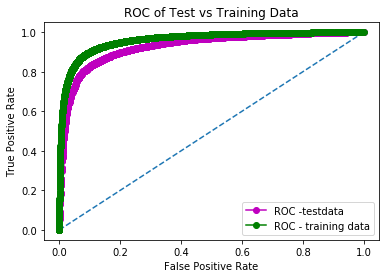

In [19]:
plt.plot(fpr_test, tpr_test, color='m', marker='o',label='ROC -testdata')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_tr, tpr_tr, linestyle='-', color='g', marker='o', label='ROC - training data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Test vs Training Data')
plt.legend()

***printing top 25 features of both positive and negative class***

In [20]:
features = bow_object.get_feature_names()
featuresAndcoeff = sorted(zip(lr.coef_[0], features))
top_features = zip(featuresAndcoeff[:25],featuresAndcoeff[:-(25+1): -1] )
print('\t\t\t\tNegative\t\t\t\t\t\t\tPositive')
print('-' * 120)

for (wn1, fn1), (wp1, fp1) in top_features:
    print('{:>20} {:>20}                                {:>20} {:>20}'.format(wn1, fn1, wp1, fp1))

				Negative							Positive
------------------------------------------------------------------------------------------------------------------------
-0.020185824578051955           disappoint                                0.021432055372532406                great
-0.019669834208765617                  not                                 0.01637683548900769                 love
-0.014186441539679963                worst                                0.014175885995926165                 best
-0.013544208413746312              horribl                                 0.01158254463326989               delici
-0.013420033372973412                   aw                                0.009733996613748186              perfect
-0.013373789571688263              terribl                                0.009528341674512544              favorit
-0.013235463833743822                money                                0.009173642119445715                 good
-0.012896980707915512                th

***adding noise on train data so as to check multicollinearity***

In [21]:
x = xtr
print(type(x))
print(x.shape)
x[x.nonzero()] = x[x.nonzero()] + np.random.normal(0,1)
x = x.toarray()
print(x.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(64000, 31507)
(64000, 31507)


***training logistic regression on perturbed data***:

In [22]:
%%time
from sklearn.linear_model import LogisticRegression

auc_cv_dict = {}
auc_tr_dict = {}

c_val = [10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 10**1, 10 ** 2, 10 ** 3, 10** 4]

for i in c_val:
    lr = LogisticRegression(penalty='l1', C=i, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='saga')
    lr.fit(x, ytr)
    y_pred_cv = lr.predict_proba(xcv)        
    fpr_cv, tpr_cv, thresholds_cv = roc_curve(ycv, y_pred_cv[:,1])
    auc_cv_dict[i] = auc(fpr_cv, tpr_cv)    
    #performance metrics for training data:
    y_pred_tr = lr.predict_proba(x)
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(ytr, y_pred_tr[:,1])
    auc_tr_dict[i] = auc(fpr_tr, tpr_tr)

/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reac

CPU times: user 23min 46s, sys: 8.18 s, total: 23min 54s
Wall time: 23min 33s


***optimal C on perturbed data***

In [23]:
#sorting dictionary wrt higest AuC Score of both training and cv data:

cv_tup = sorted(auc_cv_dict.items(), key= lambda x: x[1],reverse=True)
tr_tup = sorted(auc_tr_dict.items(), key= lambda x: x[1],reverse=True)
print(cv_tup)
print('*' * 70)
print(tr_tup)

[(0.01, 0.9287825104319011), (0.1, 0.9240653368274565), (10, 0.9233618680458467), (100, 0.9233560292952265), (10000, 0.9233555595106939), (1000, 0.9233554923986178), (0.001, 0.9216053436782573), (0.0001, 0.711610147560664)]
**********************************************************************
[(10000, 0.9667318453233119), (1000, 0.966731807314386), (100, 0.9667315198718825), (10, 0.9667286145645961), (0.1, 0.9664034980887959), (0.01, 0.9618909311013599), (0.001, 0.9247573553513722), (0.0001, 0.7057779703690061)]


***plotting cv vs perturbed training data***

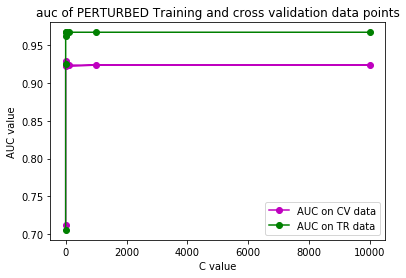

In [24]:
plt.plot([x[0] for x in cv_tup], [x[1] for x in cv_tup], linestyle='-', color='m', marker='o',label='AUC on CV data')
plt.plot([x[0] for x in tr_tup], [x[1] for x in tr_tup], linestyle='-', color='g', marker='o', label='AUC on TR data')
#plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("C value")
plt.ylabel('AUC value')
plt.title('auc of PERTURBED Training and cross validation data points')
plt.legend()

***optimal BoW-LR on PERTURBED train and test data***

In [25]:
lr = LogisticRegression(penalty='l1', C=0.01, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='saga')
lr.fit(x, ytr)
y_pred_test = lr.predict_proba(xtest)
y_pred = lr.predict(xtest)
fpr_test, tpr_test, thresholds_test= roc_curve(ytest, y_pred_test[:,1])
auc_test = auc(fpr_test, tpr_test)
optimal_weight_perturbed = lr.coef_
print(auc_test)


0.9317462011279617


/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


***confusion matrix on test data***

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs


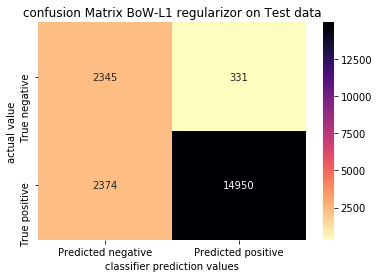

In [26]:
%time
y_pred_test = np.where(y_pred_test[:,1] < 0.5, 0, 1)
#creating confusion matrix:

cf = confusion_matrix(ytest, y_pred_test)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix BoW-L1 regularizor on Test data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

***confusion matrix on PERTURBED training data***

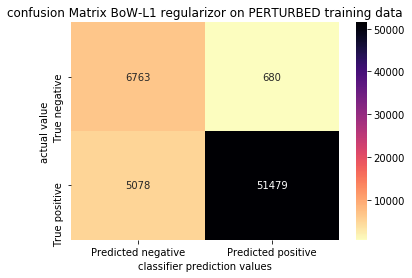

In [27]:
y_pred_tr = np.where(y_pred_tr[:,1] > 0.5, 1, 0)
#creating confusion matrix:

cf = confusion_matrix(ytr, y_pred_tr)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix BoW-L1 regularizor on PERTURBED training data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

***ROC-AUC curve for PERTURBED train and test data***

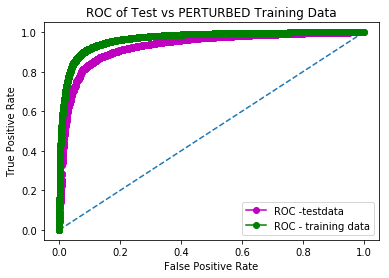

In [28]:
plt.plot(fpr_test, tpr_test, color='m', marker='o',label='ROC -testdata')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_tr, tpr_tr, linestyle='-', color='g', marker='o', label='ROC - training data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Test vs PERTURBED Training Data')
plt.legend()

***checking multicollinearity***

In [29]:
optimal_weight = optimal_weight + 10 ** -6
optimal_weight_perturbed = optimal_weight_perturbed + 10 ** -6
print(optimal_weight.shape)
print(optimal_weight_perturbed.shape)
print('************************************')

#flattening:
weights_ravel = np.ravel(optimal_weight)
weights_perturbed_ravel = np.ravel(optimal_weight_perturbed)

print(len(weights_ravel))
print(len(weights_perturbed_ravel))


#creating a list of delta:
w = list(weights_ravel)
w1 = list(weights_perturbed_ravel)
delta_list = []
for i in range(0, len(w)):
    delta_list.append(np.abs((w[i] - w1[i]) / w[i] * 100))

(1, 31507)
(1, 31507)
************************************
31507
31507


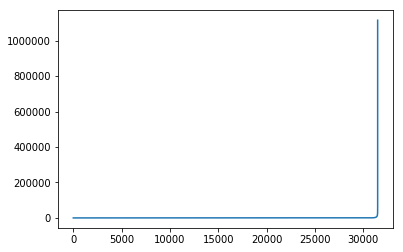

In [30]:
plt.plot(sorted(delta_list))
plt.show()

***we could see from the plot above after a value , there's significant change in the dataset so we could come onto conclusion that features are multicollineaer***

***BoW-L1 -- checking sparcity with different decreased value of C***

In [31]:
lr = LogisticRegression(C= 10, class_weight='balanced',penalty= 'l1')
lr.fit(xtr,ytr)
ypred = lr.predict(xtest)
print('F1-Score on test set is : {:<.3f}'.format(f1_score(ytest, ypred)))
print('Non Zero element count is {}'.format(np.count_nonzero(lr.coef_)))

F1-Score on test set is : 0.912
Non Zero element count is 15236


/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [32]:
%%time
lr = LogisticRegression(C= 1, class_weight='balanced',penalty= 'l1')
lr.fit(xtr,ytr)
ypred = lr.predict(xtest)
print('F1-Score on test set is : {:<.3f}'.format(f1_score(ytest, ypred)))
print('Non Zero element count is {}'.format(np.count_nonzero(lr.coef_)))

F1-Score on test set is : 0.917
Non Zero element count is 11169
CPU times: user 34 s, sys: 4 ms, total: 34 s
Wall time: 34 s


In [33]:
%%time
lr = LogisticRegression(C= 0.1, class_weight='balanced',penalty= 'l1')
lr.fit(xtr,ytr)
ypred = lr.predict(xtest)
print('F1-Score on test set is : {:<.3f}'.format(f1_score(ytest, ypred)))
print('Non Zero element count is {}'.format(np.count_nonzero(lr.coef_)))

F1-Score on test set is : 0.929
Non Zero element count is 9779
CPU times: user 2.84 s, sys: 0 ns, total: 2.84 s
Wall time: 2.84 s


In [34]:
%%time
lr = LogisticRegression(C= 0.01, class_weight='balanced',penalty= 'l1')
lr.fit(xtr,ytr)
ypred = lr.predict(xtest)
print('F1-Score on test set is : {:<.3f}'.format(f1_score(ytest, ypred)))
print('Non Zero element count is {}'.format(np.count_nonzero(lr.coef_)))

F1-Score on test set is : 0.930
Non Zero element count is 4062
CPU times: user 1.37 s, sys: 0 ns, total: 1.37 s
Wall time: 1.37 s


# LR on BoW(L2)

In [35]:
%%time
from sklearn.linear_model import LogisticRegression

auc_cv_dict = {}
auc_tr_dict = {}

c_val = [10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 10**1, 10 ** 2, 10 ** 3, 10** 4]

for i in c_val:
    lr = LogisticRegression(penalty='l2', C=i, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='sag')
    lr.fit(xtr, ytr)
    y_pred_cv = lr.predict_proba(xcv)        
    fpr_cv, tpr_cv, thresholds_cv = roc_curve(ycv, y_pred_cv[:,1])
    auc_cv_dict[i] = auc(fpr_cv, tpr_cv)    
    #performance metrics for training data:
    y_pred_tr = lr.predict_proba(xtr)
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(ytr, y_pred_tr[:,1])
    auc_tr_dict[i] = auc(fpr_tr, tpr_tr)

/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reac

CPU times: user 2.17 s, sys: 28 ms, total: 2.2 s
Wall time: 2.69 s


/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


***optimal C***

In [36]:
#sorting dictionary wrt higest AuC Score of both training and cv data:

cv_tup = sorted(auc_cv_dict.items(), key= lambda x: x[1],reverse=True)
tr_tup = sorted(auc_tr_dict.items(), key= lambda x: x[1],reverse=True)
print(cv_tup)
print('*' * 70)
print(tr_tup)


[(0.0001, 0.9222189829460161), (0.001, 0.9221585820775322), (0.01, 0.9221518708699228), (0.1, 0.9221513675293522), (10, 0.9221513339733142), (10000, 0.9221513004172761), (100, 0.9221513004172761), (1000, 0.9221513004172761)]
**********************************************************************
[(0.0001, 0.9648523063047845), (0.001, 0.9648224146599895), (0.01, 0.9648194024525987), (0.1, 0.96481894159437), (10000, 0.9648189130876756), (100, 0.9648189130876756), (1000, 0.9648189130876756), (10, 0.9648189130876756)]


***plotting ROC-AUC on train vs cv data***

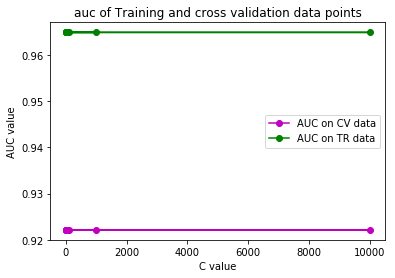

In [37]:
plt.plot([x[0] for x in cv_tup], [x[1] for x in cv_tup], linestyle='-', color='m', marker='o',label='AUC on CV data')
plt.plot([x[0] for x in tr_tup], [x[1] for x in tr_tup], linestyle='-', color='g', marker='o', label='AUC on TR data')
#plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("C value")
plt.ylabel('AUC value')
plt.title('auc of Training and cross validation data points')
plt.legend()

***Optimal L2-BoW***

In [38]:
lr = LogisticRegression(penalty='l2', C=0.0001, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='sag')
lr.fit(xtr, ytr)
y_pred_test = lr.predict_proba(xtest)
y_pred = lr.predict(xtest)
fpr_test, tpr_test, thresholds_test= roc_curve(ytest, y_pred_test[:,1])
auc_test = auc(fpr_test, tpr_test)
print(auc_test)

0.9263315055985648


/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


***confusion matrix on test data***

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


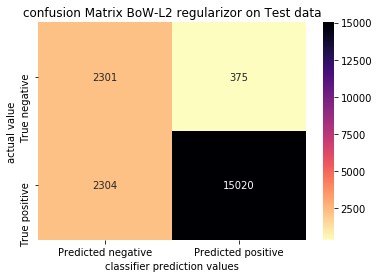

In [39]:
%time
y_pred_test = np.where(y_pred_test[:,1] < 0.5, 0, 1)
#creating confusion matrix:

cf = confusion_matrix(ytest, y_pred_test)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix BoW-L2 regularizor on Test data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

***confusion matrix on training data***

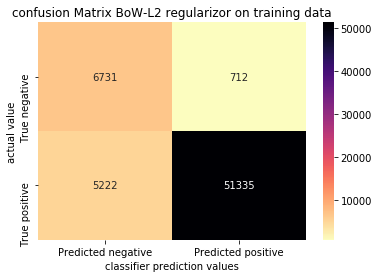

In [40]:
y_pred_tr = np.where(y_pred_tr[:,1] > 0.5, 1, 0)
#creating confusion matrix:

cf = confusion_matrix(ytr, y_pred_tr)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix BoW-L2 regularizor on training data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

***ROC-AUC on test vs training data***

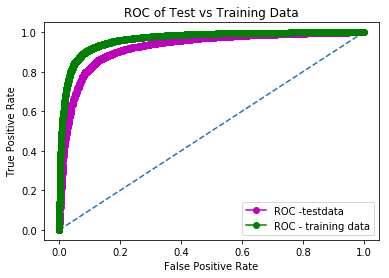

In [41]:
plt.plot(fpr_test, tpr_test, color='m', marker='o',label='ROC -testdata')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_tr, tpr_tr, linestyle='-', color='g', marker='o', label='ROC - training data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Test vs Training Data')
plt.legend()

***top 25 features for both positive and negative class***

In [42]:
features = bow_object.get_feature_names()
featuresAndcoeff = sorted(zip(lr.coef_[0], features))
top_features = zip(featuresAndcoeff[:25],featuresAndcoeff[:-(25+1): -1] )
print('\t\t\t\tNegative\t\t\t\t\t\t\tPositive')
print('-' * 120)

for (wn1, fn1), (wp1, fp1) in top_features:
    print('{:>20} {:>20}                                {:>20} {:>20}'.format(wn1, fn1, wp1, fp1))

				Negative							Positive
------------------------------------------------------------------------------------------------------------------------
-0.03636758861347394                  not                                0.043531071634431276                great
-0.03515925598576446           disappoint                                 0.03400131907910012                 love
-0.02250723580278787                worst                                 0.02899878560414292                 best
-0.022285978723451973                money                                0.022707208514560547               delici
-0.022130438063942905                  bad                                 0.01915329833162593                 good
-0.021732960422216036              horribl                                0.018795667664374214              perfect
-0.021493750158529883                   aw                                 0.01858567358658857              favorit
 -0.0214920046296824              terribl 

# TfIDF(L1)

In [43]:
xt, xtest, yt, ytest = train_test_split(tfidf, y, test_size=0.2, shuffle=False)
xtr, xcv, ytr, ycv = train_test_split(xt, yt, test_size=0.2, shuffle=False)

***tf-Idf featurizer***

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_object = TfidfVectorizer(ngram_range=(1,1))
xtr = tfidf_object.fit_transform(xtr)
xcv = tfidf_object.transform(xcv)
xtest = tfidf_object.transform(xtest)

***data standardization***

In [45]:
xtr = sc.fit_transform(xtr)
xcv = sc.transform(xcv)
xtest = sc.transform(xtest)
print(xtr.shape, ytr.shape)
print(xcv.shape, ycv.shape)
print(xtest.shape, ytest.shape)

(64000, 45293) (64000,)
(16000, 45293) (16000,)
(20000, 45293) (20000,)


***TfIdf-BoW***

In [46]:
%%time

auc_cv_dict = {}
auc_tr_dict = {}

c_val = [10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 10**1, 10 ** 2, 10 ** 3, 10** 4]

for i in c_val:
    lr = LogisticRegression(penalty='l1', C=i, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='saga')
    lr.fit(xtr, ytr)
    y_pred_cv = lr.predict_proba(xcv)        
    fpr_cv, tpr_cv, thresholds_cv = roc_curve(ycv, y_pred_cv[:,1])
    auc_cv_dict[i] = auc(fpr_cv, tpr_cv)    
    #performance metrics for training data:
    y_pred_tr = lr.predict_proba(xtr)
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(ytr, y_pred_tr[:,1])
    auc_tr_dict[i] = auc(fpr_tr, tpr_tr)

/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reac

CPU times: user 4min 28s, sys: 60 ms, total: 4min 28s
Wall time: 4min 28s


/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


***optimal C***

In [47]:
#sorting dictionary wrt higest AuC Score of both training and cv data:

cv_tup = sorted(auc_cv_dict.items(), key= lambda x: x[1],reverse=True)
tr_tup = sorted(auc_tr_dict.items(), key= lambda x: x[1],reverse=True)
print(cv_tup)
print('*' * 70)
print(tr_tup)


[(0.01, 0.939793655868602), (0.1, 0.936522311275473), (10, 0.936053801872266), (100, 0.9360504462684613), (1000, 0.9360499093718523), (10000, 0.9360498758158142), (0.001, 0.9301817636624079), (0.0001, 0.6347100603954995)]
**********************************************************************
[(10000, 0.976002704629659), (1000, 0.9760026737474066), (100, 0.9760024742005446), (10, 0.9760008065589134), (0.1, 0.9757923608572382), (0.01, 0.9726462123864053), (0.001, 0.9333498954853118), (0.0001, 0.6319512282953859)]


***AUC of train vs CV datapoints***

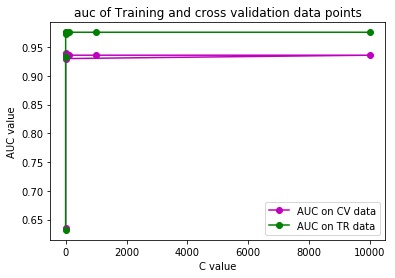

In [48]:
plt.plot([x[0] for x in cv_tup], [x[1] for x in cv_tup], linestyle='-', color='m', marker='o',label='AUC on CV data')
plt.plot([x[0] for x in tr_tup], [x[1] for x in tr_tup], linestyle='-', color='g', marker='o', label='AUC on TR data')
#plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("C value")
plt.ylabel('AUC value')
plt.title('auc of Training and cross validation data points')
plt.legend()

***tfidf model on optimal C = 0.01***

In [49]:
%%time

lr = LogisticRegression(penalty='l1', C=0.01, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='saga')
lr.fit(xtr, ytr)
y_pred_test = lr.predict_proba(xtest)
y_pred = lr.predict(xtest)
fpr_test, tpr_test, thresholds_test= roc_curve(ytest, y_pred_test[:,1])
auc_test = auc(fpr_test, tpr_test)
print(auc_test)

0.9374070299668087
CPU times: user 31.7 s, sys: 84 ms, total: 31.7 s
Wall time: 31.6 s


/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


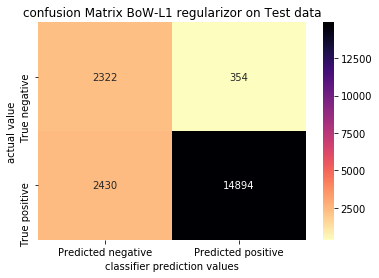

In [50]:
%time
y_pred_test = np.where(y_pred_test[:,1] < 0.5, 0, 1)
#creating confusion matrix:

cf = confusion_matrix(ytest, y_pred_test)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix BoW-L1 regularizor on Test data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

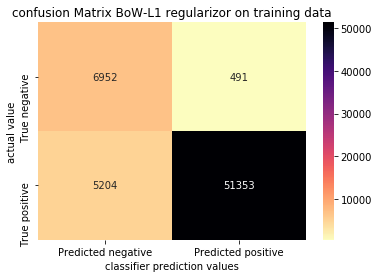

In [51]:
y_pred_tr = np.where(y_pred_tr[:,1] > 0.5, 1, 0)
#creating confusion matrix:

cf = confusion_matrix(ytr, y_pred_tr)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix BoW-L1 regularizor on training data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

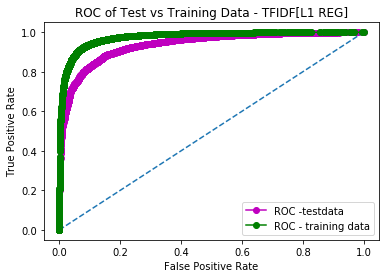

In [52]:
plt.plot(fpr_test, tpr_test, color='m', marker='o',label='ROC -testdata')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_tr, tpr_tr, linestyle='-', color='g', marker='o', label='ROC - training data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Test vs Training Data - TFIDF[L1 REG]')
plt.legend()

In [53]:
features = tfidf_object.get_feature_names()
featuresAndcoeff = sorted(zip(lr.coef_[0], features))
top_features = zip(featuresAndcoeff[:25],featuresAndcoeff[:-(25+1): -1] )
print('\t\t\t\tNegative\t\t\t\t\t\t\tPositive')
print('-' * 120)

for (wn1, fn1), (wp1, fp1) in top_features:
    print('{:>20} {:>20}                                {:>20} {:>20}'.format(wn1, fn1, wp1, fp1))

				Negative							Positive
------------------------------------------------------------------------------------------------------------------------
-0.026316998451721432                  not                                0.024685912449091768                  and
-0.016277134113167013                  was                                0.022330237182991004                great
-0.015639578457239404                worst                                 0.01698941308149067                   is
-0.015299290993678188         disappointed                                0.015026057297874665                 best
-0.01485286094252556             terrible                                0.014748187414641279                  for
-0.014724488056589463                awful                                 0.01335684876421827                 love
-0.014327472210215221             horrible                                0.013046344188651717                   my
-0.01352757901359064                wast

# TFidf-L2 regulrizer

In [54]:
%%time
from sklearn.linear_model import LogisticRegression

auc_cv_dict = {}
auc_tr_dict = {}

c_val = [10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 10**1, 10 ** 2, 10 ** 3, 10** 4]

for i in c_val:
    lr = LogisticRegression(penalty='l2', C=i, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='sag')
    lr.fit(xtr, ytr)
    y_pred_cv = lr.predict_proba(xcv)        
    fpr_cv, tpr_cv, thresholds_cv = roc_curve(ycv, y_pred_cv[:,1])
    auc_cv_dict[i] = auc(fpr_cv, tpr_cv)    
    #performance metrics for training data:
    y_pred_tr = lr.predict_proba(xtr)
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(ytr, y_pred_tr[:,1])
    auc_tr_dict[i] = auc(fpr_tr, tpr_tr)

/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reac

CPU times: user 3.06 s, sys: 28 ms, total: 3.09 s
Wall time: 3.58 s


/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


***optimal C***

In [55]:
#sorting dictionary wrt higest AuC Score of both training and cv data:

cv_tup = sorted(auc_cv_dict.items(), key= lambda x: x[1],reverse=True)
tr_tup = sorted(auc_tr_dict.items(), key= lambda x: x[1],reverse=True)
print(cv_tup)
print('*' * 70)
print(tr_tup)


[(0.0001, 0.9294887979207069), (0.001, 0.9294252427846466), (0.01, 0.9294175248958958), (0.1, 0.9294164175466403), (10000, 0.9294161826543739), (100, 0.9294161826543739), (1000, 0.9294161826543739), (10, 0.9294161826543739)]
**********************************************************************
[(0.0001, 0.9782271247655423), (0.001, 0.9781899900447734), (0.01, 0.9781862794233659), (0.1, 0.9781859397185892), (10000, 0.9781858945829895), (100, 0.9781858945829895), (1000, 0.9781858945829895), (10, 0.9781858945829895)]


***AUC of train vs cv data***

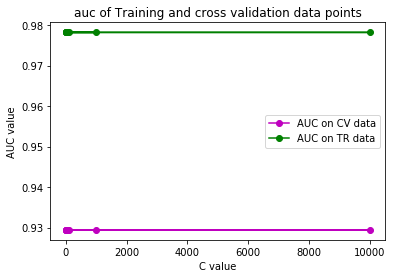

In [56]:
plt.plot([x[0] for x in cv_tup], [x[1] for x in cv_tup], linestyle='-', color='m', marker='o',label='AUC on CV data')
plt.plot([x[0] for x in tr_tup], [x[1] for x in tr_tup], linestyle='-', color='g', marker='o', label='AUC on TR data')
#plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("C value")
plt.ylabel('AUC value')
plt.title('auc of Training and cross validation data points')
plt.legend()

***optimal tfidf(L2)***

In [57]:
lr = LogisticRegression(penalty='l2', C=0.0001, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='sag')
lr.fit(xtr, ytr)
y_pred_test = lr.predict_proba(xtest)
y_pred = lr.predict(xtest)
fpr_test, tpr_test, thresholds_test= roc_curve(ytest, y_pred_test[:,1])
auc_test = auc(fpr_test, tpr_test)
print(auc_test)

0.9288325397014399


/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


***confusion matrix on test data***

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


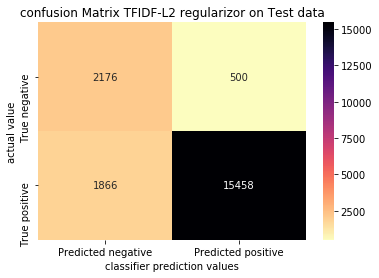

In [58]:
%time
y_pred_test = np.where(y_pred_test[:,1] < 0.5, 0, 1)
#creating confusion matrix:

cf = confusion_matrix(ytest, y_pred_test)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix TFIDF-L2 regularizor on Test data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

***confusion matrix on train data***

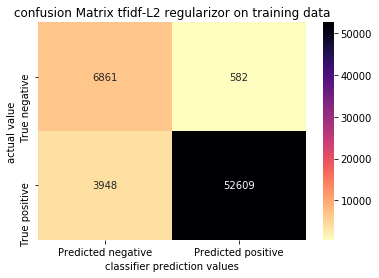

In [59]:
y_pred_tr = np.where(y_pred_tr[:,1] > 0.5, 1, 0)
#creating confusion matrix:

cf = confusion_matrix(ytr, y_pred_tr)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix tfidf-L2 regularizor on training data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

***ROC of train vs test data***

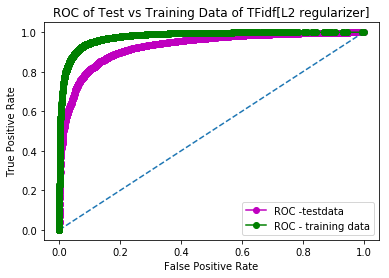

In [60]:
plt.plot(fpr_test, tpr_test, color='m', marker='o',label='ROC -testdata')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_tr, tpr_tr, linestyle='-', color='g', marker='o', label='ROC - training data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Test vs Training Data of TFidf[L2 regularizer]')
plt.legend()

***top 25 positive and negative reviews***

In [61]:
features = tfidf_object.get_feature_names()
featuresAndcoeff = sorted(zip(lr.coef_[0], features))
top_features = zip(featuresAndcoeff[:25],featuresAndcoeff[:-(25+1): -1] )
print('\t\t\t\tNegative\t\t\t\t\t\t\tPositive')
print('-' * 120)

for (wn1, fn1), (wp1, fp1) in top_features:
    print('{:>20} {:>20}                                {:>20} {:>20}'.format(wn1, fn1, wp1, fp1))

				Negative							Positive
------------------------------------------------------------------------------------------------------------------------
  -0.030586216068246                  not                                0.029215636799053597                great
-0.023303750268383928                worst                                0.025919424212112435                  and
-0.02271190079113811         disappointed                                0.021369708002574664                 best
-0.02222171328634551             terrible                                0.019379759234883866                   is
-0.02204217089522468                awful                                 0.01876832356616267                 love
-0.021765058044845784             horrible                                 0.01769458919240648            delicious
-0.02022203096979263                waste                                0.017586523470395025                  for
-0.019974131605316477                threw  

# Avg-W2V --L1

In [6]:
#train, cv, test split:
print(type(w2v))
xtrain, xtest, ytrain, ytest = train_test_split(w2v, y, test_size=0.2, shuffle=False)
xtr, xcv, ytr, ycv = train_test_split(xtrain, ytrain, test_size=0.2, shuffle=False)

<class 'pandas.core.series.Series'>


***list of lists of train, cv, test data***

In [7]:
%%time

#training list of words:
train_list = []
for sentence in xtr:
    tmp_list = []
    for word in sentence.split():
        tmp_list.append(word)
    train_list.append(tmp_list)

#cv list of words
cv_list = []
for sentence in xcv:
    tmp_list = []
    for word in sentence.split():
        tmp_list.append(word)
    cv_list.append(tmp_list)
    
#test list of words:    
test_list = []
for sentence in xtest:
    tmp_list = []
    for word in sentence.split():
        tmp_list.append(word)
    test_list.append(tmp_list)

CPU times: user 1.7 s, sys: 316 ms, total: 2.02 s
Wall time: 2.02 s


***instantiating word2vec object for Train, cv, test data***

In [8]:
%%time

from gensim.models import Word2Vec

#instantiating training,cv, test word to vector object:
trainw2v = Word2Vec(train_list, size=1000, workers=8)
cvw2v = Word2Vec(cv_list, size=1000,workers=8)
testw2v = Word2Vec(test_list, size=1000, workers=8)

#training word2vec List:
train_vocab = list(trainw2v.wv.vocab.keys())

#cv word2vec List:
cv_vocab = list(cvw2v.wv.vocab.keys())

#test word2vec List:
test_vocab = list(testw2v.wv.vocab.keys())

CPU times: user 5min 29s, sys: 1.62 s, total: 5min 31s
Wall time: 48.4 s


***Avg-W2V for train, cv, test data***

In [70]:
%%time

#avg-w2v for training data****************************:
train_vector = []
for sentence in train_list:
    vector = np.zeros(1000)
    for word in sentence:
        cnt = 0
        if word in train_vocab:
            vector = vector + trainw2v.wv[word]
            cnt = cnt + 1
    if cnt != 0:
        vector = vector / cnt
    train_vector.append(vector)
    
train_vector = np.array(train_vector)
print('train vector shape is {}'.format(train_vector.shape))


#avg-w2v for cv data***********************************:
cv_vector = []
for sentence in cv_list:
    vector = np.zeros(1000)
    for word in sentence:
        cnt = 0
        if word in cv_vocab:
            vector = vector + cvw2v.wv[word]
            cnt = cnt + 1
    if cnt != 0:
        vector = vector / cnt
    cv_vector.append(vector)
    
cv_vector = np.array(cv_vector)
print('cv vector shape is {}'.format(cv_vector.shape))




#avg-w2v for test data**********************************:    
test_vector = []
for sentence in test_list:
    vector = np.zeros(1000)
    for word in sentence:
        cnt = 0
        if word in test_vocab:
            vector = vector + testw2v.wv[word]
            cnt = cnt + 1
    if cnt != 0:
        vector = vector / cnt
    test_vector.append(vector)
    
test_vector = np.array(test_vector)
print('test vector shape is {}'.format(test_vector.shape)) 

train vector shape is (64000, 1000)
cv vector shape is (16000, 1000)
test vector shape is (20000, 1000)
CPU times: user 40min 24s, sys: 6.15 s, total: 40min 30s
Wall time: 40min 20s


***column standardization***

In [71]:
sc = StandardScaler(with_mean=False)
xtr = sc.fit_transform(train_vector)
xcv = sc.transform(cv_vector)
xtest = sc.transform(test_vector)

***L1 regularizer***

In [72]:
%%time

auc_cv_dict = {}
auc_tr_dict = {}

c_val = [10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 10**1, 10 ** 2, 10 ** 3, 10** 4]

for i in c_val:
    lr = LogisticRegression(penalty='l1', C=i, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='saga')
    lr.fit(xtr, ytr)
    y_pred_cv = lr.predict_proba(xcv)        
    fpr_cv, tpr_cv, thresholds_cv = roc_curve(ycv, y_pred_cv[:,1])
    auc_cv_dict[i] = auc(fpr_cv, tpr_cv)    
    #performance metrics for training data:
    y_pred_tr = lr.predict_proba(xtr)
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(ytr, y_pred_tr[:,1])
    auc_tr_dict[i] = auc(fpr_tr, tpr_tr)

/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reac

CPU times: user 52.2 s, sys: 10.2 s, total: 1min 2s
Wall time: 47.1 s


/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


***optimal C value for AUC score on training and CV data***

In [73]:
#sorting dictionary wrt higest AuC Score of both training and cv data:

cv_tup = sorted(auc_cv_dict.items(), key= lambda x: x[1],reverse=True)
tr_tup = sorted(auc_tr_dict.items(), key= lambda x: x[1],reverse=True)
print(cv_tup)
print('*' * 70)
print(tr_tup)

[(0.001, 0.6034703788771988), (0.0001, 0.596988224783577), (0.01, 0.5917525432792357), (0.1, 0.58922463270903), (10, 0.5890893347636259), (100, 0.5890884958626748), (1000, 0.5890882945264465), (10000, 0.5890882945264464)]
**********************************************************************
[(10000, 0.8960481516174921), (1000, 0.8960481516174921), (100, 0.8960481468663763), (10, 0.8960474341990126), (0.1, 0.8959720363674821), (0.01, 0.8946331363133524), (0.001, 0.8789666124153388), (0.0001, 0.7993185752607772)]


***Plotting AUC Curve on training and cv data***

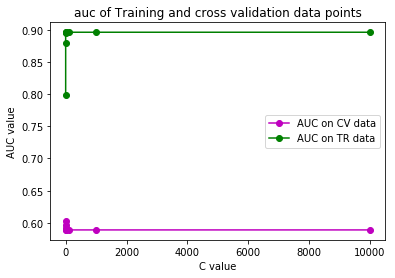

In [74]:
plt.plot([x[0] for x in cv_tup], [x[1] for x in cv_tup], linestyle='-', color='m', marker='o',label='AUC on CV data')
plt.plot([x[0] for x in tr_tup], [x[1] for x in tr_tup], linestyle='-', color='g', marker='o', label='AUC on TR data')
#plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("C value")
plt.ylabel('AUC value')
plt.title('auc of Training and cross validation data points')
plt.legend()

***optimal LR-avg-W2V(L1) for C=0.001***

In [75]:
lr = LogisticRegression(penalty='l1', C=0.001, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='saga')
lr.fit(xtr, ytr)
y_pred_test = lr.predict_proba(xtest)
y_pred = lr.predict(xtest)
fpr_test, tpr_test, thresholds_test= roc_curve(ytest, y_pred_test[:,1])
auc_test = auc(fpr_test, tpr_test)
optimal_weight = lr.coef_
print(auc_test)

0.7309565231571743


/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


***plotting confusion matrix on test data***

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.11 µs


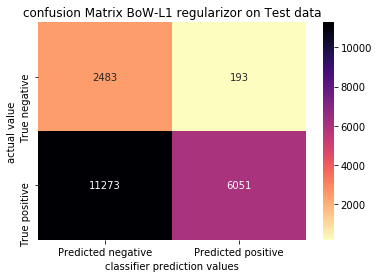

In [76]:
%time
y_pred_test = np.where(y_pred_test[:,1] < 0.5, 0, 1)
#creating confusion matrix:

cf = confusion_matrix(ytest, y_pred_test)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix BoW-L1 regularizor on Test data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

***plotting confusion matrix on train data***

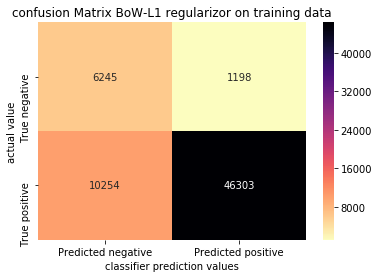

In [77]:
y_pred_tr = np.where(y_pred_tr[:,1] > 0.5, 1, 0)
#creating confusion matrix:

cf = confusion_matrix(ytr, y_pred_tr)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix BoW-L1 regularizor on training data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

***plotting ROC curve on test vs training data***

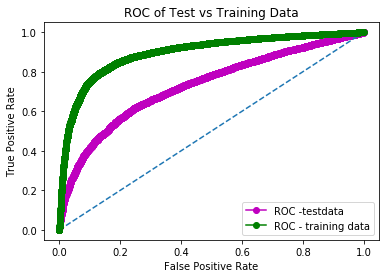

In [78]:
plt.plot(fpr_test, tpr_test, color='m', marker='o',label='ROC -testdata')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_tr, tpr_tr, linestyle='-', color='g', marker='o', label='ROC - training data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Test vs Training Data')
plt.legend()

***printing top 25 features of both positive and negative class***

In [ ]:
features = bow_object.get_feature_names()
featuresAndcoeff = sorted(zip(lr.coef_[0], features))
top_features = zip(featuresAndcoeff[:25],featuresAndcoeff[:-(25+1): -1] )
print('\t\t\t\tNegative\t\t\t\t\t\t\tPositive')
print('-' * 120)

for (wn1, fn1), (wp1, fp1) in top_features:
    print('{:>20} {:>20}                                {:>20} {:>20}'.format(wn1, fn1, wp1, fp1))

# Avg-W2v L2 regularizer

In [79]:
%%time
from sklearn.linear_model import LogisticRegression

auc_cv_dict = {}
auc_tr_dict = {}

c_val = [10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 10**1, 10 ** 2, 10 ** 3, 10** 4]

for i in c_val:
    lr = LogisticRegression(penalty='l2', C=i, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='sag')
    lr.fit(xtr, ytr)
    y_pred_cv = lr.predict_proba(xcv)        
    fpr_cv, tpr_cv, thresholds_cv = roc_curve(ycv, y_pred_cv[:,1])
    auc_cv_dict[i] = auc(fpr_cv, tpr_cv)    
    #performance metrics for training data:
    y_pred_tr = lr.predict_proba(xtr)
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(ytr, y_pred_tr[:,1])
    auc_tr_dict[i] = auc(fpr_tr, tpr_tr)

/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reac

CPU times: user 24.8 s, sys: 9.92 s, total: 34.7 s
Wall time: 19.3 s


/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


***optimal C***

In [80]:
#sorting dictionary wrt higest AuC Score of both training and cv data:

cv_tup = sorted(auc_cv_dict.items(), key= lambda x: x[1],reverse=True)
tr_tup = sorted(auc_tr_dict.items(), key= lambda x: x[1],reverse=True)
print(cv_tup)
print('*' * 70)
print(tr_tup)


[(0.0001, 0.5918883781212484), (0.001, 0.5883229484106787), (0.01, 0.5879353090591639), (0.1, 0.5878969209516385), (10, 0.5878938337961382), (10000, 0.5878938002401002), (100, 0.5878938002401002), (1000, 0.5878938002401002)]
**********************************************************************
[(100, 0.8956667177910478), (10000, 0.8956667154154899), (1000, 0.8956667154154899), (10, 0.8956667035377006), (0.1, 0.8956661167749044), (0.01, 0.8956603655492786), (0.001, 0.8955974275188251), (0.0001, 0.8945316002184764)]


***AUC of train vs cv data***

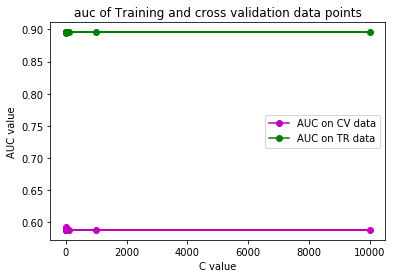

In [81]:
plt.plot([x[0] for x in cv_tup], [x[1] for x in cv_tup], linestyle='-', color='m', marker='o',label='AUC on CV data')
plt.plot([x[0] for x in tr_tup], [x[1] for x in tr_tup], linestyle='-', color='g', marker='o', label='AUC on TR data')
#plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("C value")
plt.ylabel('AUC value')
plt.title('auc of Training and cross validation data points')
plt.legend()

***optimal avg-W2V(L2)***

In [82]:
lr = LogisticRegression(penalty='l2', C=0.0001, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='sag')
lr.fit(xtr, ytr)
y_pred_test = lr.predict_proba(xtest)
y_pred = lr.predict(xtest)
fpr_test, tpr_test, thresholds_test= roc_curve(ytest, y_pred_test[:,1])
auc_test = auc(fpr_test, tpr_test)
print(auc_test)

0.7076581896978676


/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


***confusion matrix on test data***

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10 µs


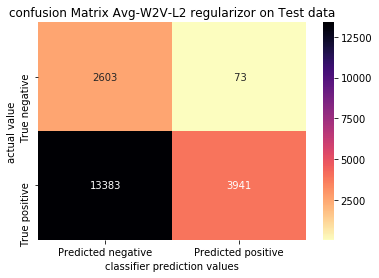

In [83]:
%time
y_pred_test = np.where(y_pred_test[:,1] < 0.5, 0, 1)
#creating confusion matrix:

cf = confusion_matrix(ytest, y_pred_test)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix Avg-W2V-L2 regularizor on Test data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

***confusion matrix on train data***

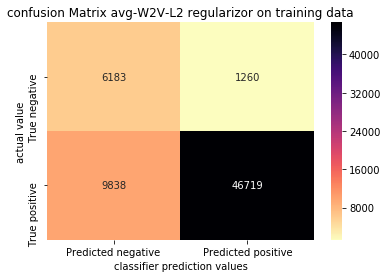

In [84]:
y_pred_tr = np.where(y_pred_tr[:,1] > 0.5, 1, 0)
#creating confusion matrix:

cf = confusion_matrix(ytr, y_pred_tr)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix avg-W2V-L2 regularizor on training data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

***ROC of train vs test data***

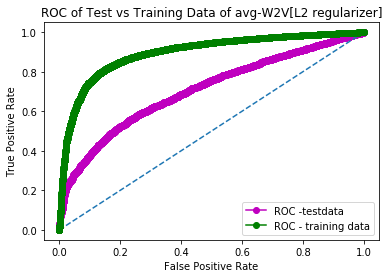

In [85]:
plt.plot(fpr_test, tpr_test, color='m', marker='o',label='ROC -testdata')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_tr, tpr_tr, linestyle='-', color='g', marker='o', label='ROC - training data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Test vs Training Data of avg-W2V[L2 regularizer]')
plt.legend()

# Feature enginnering on AVG-W2V

In [86]:
type(w2v_featured)

pandas.core.series.Series

In [87]:
#train, cv, test split:
print(type(w2v))
xtrain, xtest, ytrain, ytest = train_test_split(w2v_featured, y, test_size=0.2, shuffle=False)
xtr, xcv, ytr, ycv = train_test_split(xtrain, ytrain, test_size=0.2, shuffle=False)

<class 'pandas.core.series.Series'>


***list of lists of train, cv, test data***

In [88]:
%%time

#training list of words:
train_list = []
for sentence in xtr:
    tmp_list = []
    for word in sentence.split():
        tmp_list.append(word)
    train_list.append(tmp_list)

#cv list of words
cv_list = []
for sentence in xcv:
    tmp_list = []
    for word in sentence.split():
        tmp_list.append(word)
    cv_list.append(tmp_list)
    
#test list of words:    
test_list = []
for sentence in xtest:
    tmp_list = []
    for word in sentence.split():
        tmp_list.append(word)
    test_list.append(tmp_list)

CPU times: user 3.26 s, sys: 72 ms, total: 3.34 s
Wall time: 3.33 s


***instantiating word2vec object for Train, cv, test data***

In [90]:
%%time

from gensim.models import Word2Vec

#instantiating training,cv, test word to vector object:
trainw2v = Word2Vec(train_list, size=1000, workers=8)
cvw2v = Word2Vec(cv_list, size=1000,workers=8)
testw2v = Word2Vec(test_list, size=1000, workers=8)

#training word2vec List:
train_vocab = list(trainw2v.wv.vocab.keys())

#cv word2vec List:
cv_vocab = list(cvw2v.wv.vocab.keys())

#test word2vec List:
test_vocab = list(testw2v.wv.vocab.keys())

CPU times: user 4min 41s, sys: 1.53 s, total: 4min 43s
Wall time: 41.9 s


***Avg-W2V for train, cv, test data***

In [91]:
%%time

#avg-w2v for training data****************************:
train_vector = []
for sentence in train_list:
    vector = np.zeros(1000)
    for word in sentence:
        cnt = 0
        if word in train_vocab:
            vector = vector + trainw2v.wv[word]
            cnt = cnt + 1
    if cnt != 0:
        vector = vector / cnt
    train_vector.append(vector)
    
train_vector = np.array(train_vector)
print('train vector shape is {}'.format(train_vector.shape))


#avg-w2v for cv data***********************************:
cv_vector = []
for sentence in cv_list:
    vector = np.zeros(1000)
    for word in sentence:
        cnt = 0
        if word in cv_vocab:
            vector = vector + cvw2v.wv[word]
            cnt = cnt + 1
    if cnt != 0:
        vector = vector / cnt
    cv_vector.append(vector)
    
cv_vector = np.array(cv_vector)
print('cv vector shape is {}'.format(cv_vector.shape))




#avg-w2v for test data**********************************:    
test_vector = []
for sentence in test_list:
    vector = np.zeros(1000)
    for word in sentence:
        cnt = 0
        if word in test_vocab:
            vector = vector + testw2v.wv[word]
            cnt = cnt + 1
    if cnt != 0:
        vector = vector / cnt
    test_vector.append(vector)
    
test_vector = np.array(test_vector)
print('test vector shape is {}'.format(test_vector.shape)) 

train vector shape is (64000, 1000)
cv vector shape is (16000, 1000)
test vector shape is (20000, 1000)
CPU times: user 47min 29s, sys: 7.46 s, total: 47min 37s
Wall time: 47min 27s


***column standardization***

In [92]:
sc = StandardScaler(with_mean=False)
xtr = sc.fit_transform(train_vector)
xcv = sc.transform(cv_vector)
xtest = sc.transform(test_vector)

***Avg-W2V[L1] regularizer on featurized text***

In [93]:
%%time

auc_cv_dict = {}
auc_tr_dict = {}

c_val = [10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 10**1, 10 ** 2, 10 ** 3, 10** 4]

for i in c_val:
    lr = LogisticRegression(penalty='l1', C=i, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='saga')
    lr.fit(xtr, ytr)
    y_pred_cv = lr.predict_proba(xcv)        
    fpr_cv, tpr_cv, thresholds_cv = roc_curve(ycv, y_pred_cv[:,1])
    auc_cv_dict[i] = auc(fpr_cv, tpr_cv)    
    #performance metrics for training data:
    y_pred_tr = lr.predict_proba(xtr)
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(ytr, y_pred_tr[:,1])
    auc_tr_dict[i] = auc(fpr_tr, tpr_tr)

/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reac

CPU times: user 52.8 s, sys: 10.1 s, total: 1min 2s
Wall time: 47.6 s


***optimal C***

In [94]:
#sorting dictionary wrt higest AuC Score of both training and cv data:

cv_tup = sorted(auc_cv_dict.items(), key= lambda x: x[1],reverse=True)
tr_tup = sorted(auc_tr_dict.items(), key= lambda x: x[1],reverse=True)
print(cv_tup)
print('*' * 70)
print(tr_tup)


[(0.01, 0.7734136584349679), (0.1, 0.7707660199210118), (10, 0.7705998504206049), (100, 0.7705976357220937), (1000, 0.7705973672737894), (10000, 0.7705972666056752), (0.001, 0.7669821739587965), (0.0001, 0.7094977614095898)]
**********************************************************************
[(1000, 0.9241721509211591), (10000, 0.924172150921159), (100, 0.924172072527749), (10, 0.9241716924384882), (0.1, 0.924121045544502), (0.01, 0.9232553732488299), (0.001, 0.9121025993660762), (0.0001, 0.8024658972572025)]


***AUC of train vs cv data***

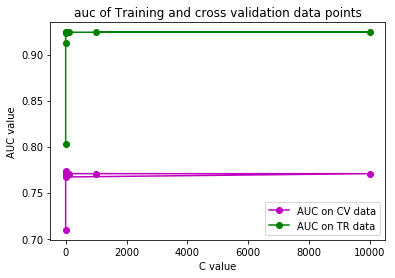

In [95]:
plt.plot([x[0] for x in cv_tup], [x[1] for x in cv_tup], linestyle='-', color='m', marker='o',label='AUC on CV data')
plt.plot([x[0] for x in tr_tup], [x[1] for x in tr_tup], linestyle='-', color='g', marker='o', label='AUC on TR data')
#plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("C value")
plt.ylabel('AUC value')
plt.title('auc of Training and cross validation data points')
plt.legend()

***optimal avg-W2V(L1) for C = 0.01***

In [97]:
%%time

lr = LogisticRegression(penalty='l1', C=0.01, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='saga')
lr.fit(xtr, ytr)
y_pred_test = lr.predict_proba(xtest)
y_pred = lr.predict(xtest)
fpr_test, tpr_test, thresholds_test= roc_curve(ytest, y_pred_test[:,1])
auc_test = auc(fpr_test, tpr_test)
print(auc_test)

0.7485325618589382
CPU times: user 6.51 s, sys: 200 ms, total: 6.71 s
Wall time: 6.43 s


/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


***confusion matrix on test data***

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


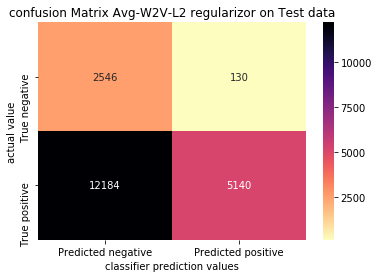

In [98]:
%time
y_pred_test = np.where(y_pred_test[:,1] < 0.5, 0, 1)
#creating confusion matrix:

cf = confusion_matrix(ytest, y_pred_test)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix Avg-W2V-L2 regularizor on Test data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

***confusion matrix on train data***

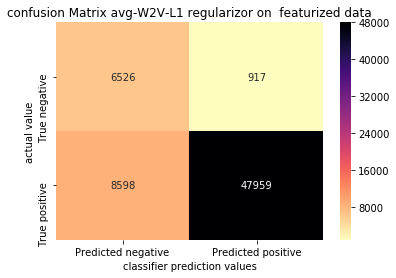

In [102]:
#y_pred_tr = np.where(y_pred_tr[:,1] > 0.5, 1, 0)
#creating confusion matrix:

cf = confusion_matrix(ytr, y_pred_tr)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix avg-W2V-L1 regularizor on  featurized data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

***ROC of train vs test data***

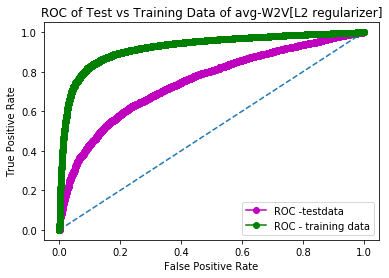

In [100]:
plt.plot(fpr_test, tpr_test, color='m', marker='o',label='ROC -testdata')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_tr, tpr_tr, linestyle='-', color='g', marker='o', label='ROC - training data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Test vs Training Data of avg-W2V[L1 regularizer with featurized text]')
plt.legend()

***Conclusion on using featurized column : we could see the performance of model on unseen data point is increaed by almost 15%(from 60.1 % to 74.6%) when we used featurized column.***

# TFidf-W2V[L1 regulazier]

In [9]:
#train, cv, test split:
print(type(w2v))
xtrain, xtest, ytrain, ytest = train_test_split(w2v, y, test_size=0.2, shuffle=False)
xtr, xcv, ytr, ycv = train_test_split(xtrain, ytrain, test_size=0.2, shuffle=False)

<class 'pandas.core.series.Series'>


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

model = TfidfVectorizer()
xtr = model.fit_transform(xtr)
xcv = model.transform(xcv)
xtest = model.transform(xtest)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

***TFIDF-W2V for training data***

In [11]:
%%time

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in train_list: # for each review/sentence 
    sent_vec = np.zeros(1000) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in train_vocab and word in tfidf_feat:
            vec = trainw2v.wv[word]            
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1

CPU times: user 1h 13min 22s, sys: 7.94 s, total: 1h 13min 29s
Wall time: 1h 13min 20s


***TFIDF-W2V for CV data***

In [12]:
%%time

tfidf_cv_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in cv_list: # for each review/sentence 
    sent_vec = np.zeros(1000) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in cv_vocab and word in tfidf_feat:
            vec = cvw2v.wv[word]            
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_cv_vectors.append(sent_vec)
    row += 1

CPU times: user 14min 41s, sys: 1.53 s, total: 14min 42s
Wall time: 14min 40s


***TFIDF-W2V for test data***

In [13]:
%%time

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in test_list: # for each review/sentence 
    sent_vec = np.zeros(1000) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in test_vocab and word in tfidf_feat:
            vec = testw2v.wv[word]            
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1

CPU times: user 19min 4s, sys: 2.44 s, total: 19min 7s
Wall time: 19min 4s


In [15]:
import pickle

file1 = open('tfidfw2v_train.pickle', 'wb')
pickle.dump(tfidf_train_vectors, file1)
file1.close()

file1 = open('tfidfw2v_cv.pickle', 'wb')
pickle.dump(tfidf_cv_vectors, file1)
file1.close()

file1 = open('tfidfw2v_test.pickle', 'wb')
pickle.dump(tfidf_test_vectors, file1)
file1.close()


***conversion of list into array***

In [16]:
xtr = np.array(tfidf_train_vectors)
xcv = np.array(tfidf_cv_vectors)
xtest = np.array(tfidf_test_vectors)

***standardizing data***

In [17]:
#standardizing the data:
sc = StandardScaler(with_mean=False)
xtr = sc.fit_transform(xtr)
xcv = sc.transform(xcv)
xtest = sc.transform(xtest)
print(xtr.shape)
print(xcv.shape)
print(xtest.shape)

(64000, 1000)
(16000, 1000)
(20000, 1000)


***TFidf-W2V [L1 regularizer]***

In [18]:
%%time

auc_cv_dict = {}
auc_tr_dict = {}

c_val = [10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 10**1, 10 ** 2, 10 ** 3, 10** 4]

for i in c_val:
    lr = LogisticRegression(penalty='l1', C=i, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='saga')
    lr.fit(xtr, ytr)
    y_pred_cv = lr.predict_proba(xcv)        
    fpr_cv, tpr_cv, thresholds_cv = roc_curve(ycv, y_pred_cv[:,1])
    auc_cv_dict[i] = auc(fpr_cv, tpr_cv)    
    #performance metrics for training data:
    y_pred_tr = lr.predict_proba(xtr)
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(ytr, y_pred_tr[:,1])
    auc_tr_dict[i] = auc(fpr_tr, tpr_tr)

/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reac

CPU times: user 40.5 s, sys: 6.83 s, total: 47.3 s
Wall time: 37 s


/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


***optimal C value for AUC score on training and CV data***

In [19]:
#sorting dictionary wrt higest AuC Score of both training and cv data:

cv_tup = sorted(auc_cv_dict.items(), key= lambda x: x[1],reverse=True)
tr_tup = sorted(auc_tr_dict.items(), key= lambda x: x[1],reverse=True)
print(cv_tup)
print('*' * 70)
print(tr_tup)

[(0.001, 0.5737799964135306), (0.01, 0.5513072492853907), (0.1, 0.5500387303791134), (10, 0.5489669505239037), (100, 0.5489482598107117), (1000, 0.5489470853493802), (10000, 0.5489469175691899), (0.0001, 0.48739400318701825)]
**********************************************************************
[(10000, 0.8995013029352956), (1000, 0.8995013005597376), (100, 0.8995010701306234), (10, 0.8994978274941182), (0.1, 0.8990692792282542), (0.01, 0.8944466692731763), (0.001, 0.8780469341868389), (0.0001, 0.715605383689763)]


***Plotting AUC Curve on training and cv data***

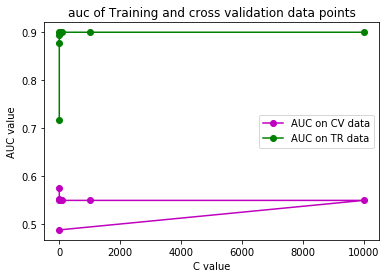

In [20]:
plt.plot([x[0] for x in cv_tup], [x[1] for x in cv_tup], linestyle='-', color='m', marker='o',label='AUC on CV data')
plt.plot([x[0] for x in tr_tup], [x[1] for x in tr_tup], linestyle='-', color='g', marker='o', label='AUC on TR data')
#plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("C value")
plt.ylabel('AUC value')
plt.title('auc of Training and cross validation data points')
plt.legend()

***optimal LR-TFidf-W2V(L1) for C=0.001***

In [21]:
lr = LogisticRegression(penalty='l1', C=0.001, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='saga')
lr.fit(xtr, ytr)
y_pred_test = lr.predict_proba(xtest)
y_pred = lr.predict(xtest)
fpr_test, tpr_test, thresholds_test= roc_curve(ytest, y_pred_test[:,1])
auc_test = auc(fpr_test, tpr_test)
optimal_weight = lr.coef_
print(auc_test)

0.6787495785070885


/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


***plotting confusion matrix on test data***

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


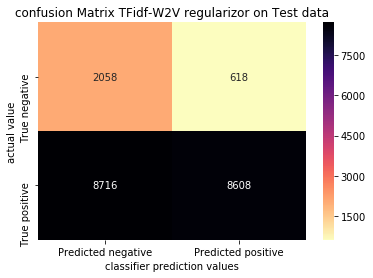

In [22]:
%time
y_pred_test = np.where(y_pred_test[:,1] < 0.5, 0, 1)
#creating confusion matrix:

cf = confusion_matrix(ytest, y_pred_test)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix TFidf-W2V regularizor on Test data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

***plotting confusion matrix on train data***

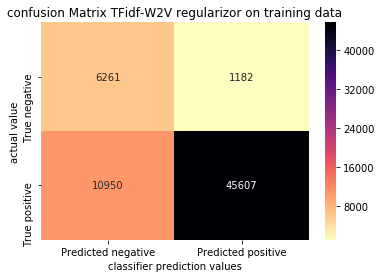

In [23]:
y_pred_tr = np.where(y_pred_tr[:,1] > 0.5, 1, 0)
#creating confusion matrix:

cf = confusion_matrix(ytr, y_pred_tr)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix TFidf-W2V regularizor on training data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

***plotting ROC curve on test vs training data***

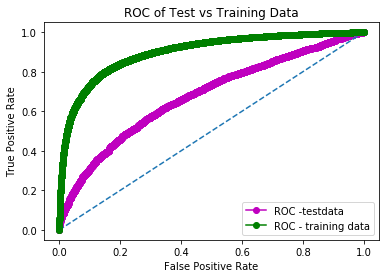

In [24]:
plt.plot(fpr_test, tpr_test, color='m', marker='o',label='ROC -testdata')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_tr, tpr_tr, linestyle='-', color='g', marker='o', label='ROC - training data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Test vs Training Data')
plt.legend()

# TF-idf-W2v [L2 regularizer]

In [25]:
%%time
from sklearn.linear_model import LogisticRegression

auc_cv_dict = {}
auc_tr_dict = {}

c_val = [10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 10**1, 10 ** 2, 10 ** 3, 10** 4]

for i in c_val:
    lr = LogisticRegression(penalty='l2', C=i, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='sag')
    lr.fit(xtr, ytr)
    y_pred_cv = lr.predict_proba(xcv)        
    fpr_cv, tpr_cv, thresholds_cv = roc_curve(ycv, y_pred_cv[:,1])
    auc_cv_dict[i] = auc(fpr_cv, tpr_cv)    
    #performance metrics for training data:
    y_pred_tr = lr.predict_proba(xtr)
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(ytr, y_pred_tr[:,1])
    auc_tr_dict[i] = auc(fpr_tr, tpr_tr)

/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reac

CPU times: user 24.2 s, sys: 6.89 s, total: 31.1 s
Wall time: 20.7 s


***optimal C***

In [26]:
#sorting dictionary wrt higest AuC Score of both training and cv data:

cv_tup = sorted(auc_cv_dict.items(), key= lambda x: x[1],reverse=True)
tr_tup = sorted(auc_tr_dict.items(), key= lambda x: x[1],reverse=True)
print(cv_tup)
print('*' * 70)
print(tr_tup)


[(0.0001, 0.5608166949074282), (0.001, 0.5442380994182188), (0.01, 0.5426059337276303), (0.1, 0.5422269853899695), (10, 0.5421829598680523), (10000, 0.5421825907516338), (1000, 0.5421825907516338), (100, 0.5421824565274815)]
**********************************************************************
[(0.01, 0.8972943407742671), (0.1, 0.8972262952943731), (10, 0.8972159188575564), (100, 0.8972159164819985), (10000, 0.8972158832241882), (1000, 0.8972158832241882), (0.001, 0.8967812701590585), (0.0001, 0.8894408509499183)]


***AUC of train vs cv data***

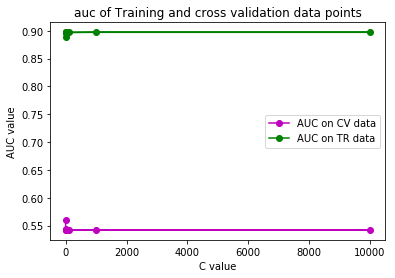

In [27]:
plt.plot([x[0] for x in cv_tup], [x[1] for x in cv_tup], linestyle='-', color='m', marker='o',label='AUC on CV data')
plt.plot([x[0] for x in tr_tup], [x[1] for x in tr_tup], linestyle='-', color='g', marker='o', label='AUC on TR data')
#plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("C value")
plt.ylabel('AUC value')
plt.title('auc of Training and cross validation data points')
plt.legend()

***optimal TFidf-W2V(L2)***

In [28]:
lr = LogisticRegression(penalty='l2', C=0.0001, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='sag')
lr.fit(xtr, ytr)
y_pred_test = lr.predict_proba(xtest)
y_pred = lr.predict(xtest)
fpr_test, tpr_test, thresholds_test= roc_curve(ytest, y_pred_test[:,1])
auc_test = auc(fpr_test, tpr_test)
print(auc_test)

0.698095887437147


/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


***confusion matrix on test data***

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


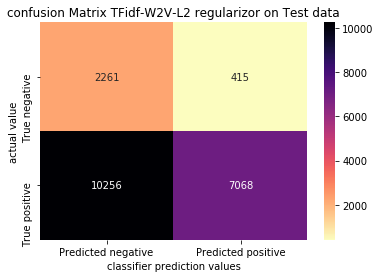

In [29]:
%time
y_pred_test = np.where(y_pred_test[:,1] < 0.5, 0, 1)
#creating confusion matrix:

cf = confusion_matrix(ytest, y_pred_test)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix TFidf-W2V-L2 regularizor on Test data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

***confusion matrix on train data***

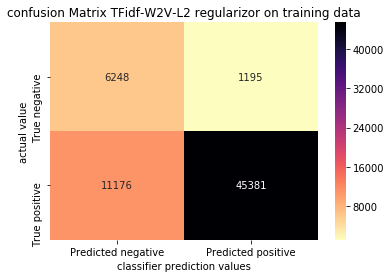

In [30]:
y_pred_tr = np.where(y_pred_tr[:,1] > 0.5, 1, 0)
#creating confusion matrix:

cf = confusion_matrix(ytr, y_pred_tr)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix TFidf-W2V-L2 regularizor on training data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

***ROC of train vs test data***

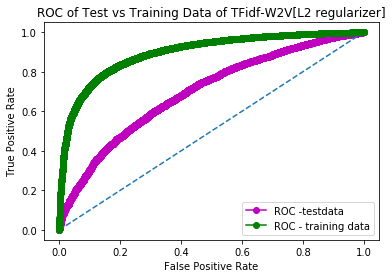

In [31]:
plt.plot(fpr_test, tpr_test, color='m', marker='o',label='ROC -testdata')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_tr, tpr_tr, linestyle='-', color='g', marker='o', label='ROC - training data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Test vs Training Data of TFidf-W2V[L2 regularizer]')
plt.legend()

# TFidf-W2V -> FeatureEngineering

In [32]:
df.columns

Index(['index', 'Score', 'Time', 'Text', 'Summary', 'cleanedtext',
       'numeric_score', 'bow_feat', 'bow_new_feat', 'tfw2v_feat'],
      dtype='object')

In [33]:
#train, cv, test split of featurized column:

xtrain, xtest, ytrain, ytest = train_test_split(w2v_featured, y, test_size=0.2, shuffle=False)
xtr, xcv, ytr, ycv = train_test_split(xtrain, ytrain, test_size=0.2, shuffle=False)

***list of lists of train, cv, test data***

In [34]:
%%time

#training list of words:
train_list = []
for sentence in xtr:
    tmp_list = []
    for word in sentence.split():
        tmp_list.append(word)
    train_list.append(tmp_list)

#cv list of words
cv_list = []
for sentence in xcv:
    tmp_list = []
    for word in sentence.split():
        tmp_list.append(word)
    cv_list.append(tmp_list)
    
#test list of words:    
test_list = []
for sentence in xtest:
    tmp_list = []
    for word in sentence.split():
        tmp_list.append(word)
    test_list.append(tmp_list)

CPU times: user 2.49 s, sys: 80 ms, total: 2.57 s
Wall time: 2.57 s


***instantiating word2vec object for Train, cv, test data***

In [35]:
%%time

from gensim.models import Word2Vec

#instantiating training,cv, test word to vector object:
trainw2v = Word2Vec(train_list, size=1000, workers=8)
cvw2v = Word2Vec(cv_list, size=1000,workers=8)
testw2v = Word2Vec(test_list, size=1000, workers=8)

#training word2vec List:
train_vocab = list(trainw2v.wv.vocab.keys())

#cv word2vec List:
cv_vocab = list(cvw2v.wv.vocab.keys())

#test word2vec List:
test_vocab = list(testw2v.wv.vocab.keys())

CPU times: user 5min 46s, sys: 1.48 s, total: 5min 48s
Wall time: 48 s


***Featurized TFidf-W2V on train, cv and test data***

In [36]:
%%time

#featurized train data:

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in train_list: # for each review/sentence 
    sent_vec = np.zeros(1000) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in train_vocab and word in tfidf_feat:
            vec = trainw2v.wv[word]            
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1
    
    
#featurized cv data:    

tfidf_cv_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in cv_list: # for each review/sentence 
    sent_vec = np.zeros(1000) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in cv_vocab and word in tfidf_feat:
            vec = cvw2v.wv[word]            
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_cv_vectors.append(sent_vec)
    row += 1
    
    
    
#featurized test data

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in test_list: # for each review/sentence 
    sent_vec = np.zeros(1000) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in test_vocab and word in tfidf_feat:
            vec = testw2v.wv[word]            
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1

CPU times: user 2h 1min 4s, sys: 13.9 s, total: 2h 1min 18s
Wall time: 2h 58s


In [37]:
#pickeling and saving it onto disc:
file1 = open('tfidfw2v_featured_train.pickle', 'wb')
pickle.dump(tfidf_train_vectors, file1)
file1.close()

file1 = open('tfidfw2v_featured_cv.pickle', 'wb')
pickle.dump(tfidf_cv_vectors, file1)
file1.close()

file1 = open('tfidfw2v_featured_test.pickle', 'wb')
pickle.dump(tfidf_test_vectors, file1)
file1.close()


***conversion of list into array***

In [38]:
xtr = np.array(tfidf_train_vectors)
xcv = np.array(tfidf_cv_vectors)
xtest = np.array(tfidf_test_vectors)

***column standardization***

In [41]:
sc = StandardScaler(with_mean=False)
xtr = sc.fit_transform(xtr)
xcv = sc.transform(xcv)
xtest = sc.transform(xtest)

***TFidf-W2V[L1] regularizer on featurized text***

In [42]:
%%time

auc_cv_dict = {}
auc_tr_dict = {}

c_val = [10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 10**1, 10 ** 2, 10 ** 3, 10** 4]

for i in c_val:
    lr = LogisticRegression(penalty='l1', C=i, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='saga')
    lr.fit(xtr, ytr)
    y_pred_cv = lr.predict_proba(xcv)        
    fpr_cv, tpr_cv, thresholds_cv = roc_curve(ycv, y_pred_cv[:,1])
    auc_cv_dict[i] = auc(fpr_cv, tpr_cv)    
    #performance metrics for training data:
    y_pred_tr = lr.predict_proba(xtr)
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(ytr, y_pred_tr[:,1])
    auc_tr_dict[i] = auc(fpr_tr, tpr_tr)

/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reac

CPU times: user 42 s, sys: 7.24 s, total: 49.3 s
Wall time: 38 s


/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


***optimal C***

In [43]:
#sorting dictionary wrt higest AuC Score of both training and cv data:

cv_tup = sorted(auc_cv_dict.items(), key= lambda x: x[1],reverse=True)
tr_tup = sorted(auc_tr_dict.items(), key= lambda x: x[1],reverse=True)
print(cv_tup)
print('*' * 70)
print(tr_tup)


[(0.001, 0.6728175219966541), (0.0001, 0.6658190747016465), (0.01, 0.6492498749030902), (0.1, 0.6168433660518127), (10, 0.6122215587074966), (100, 0.6121868617641564), (1000, 0.6121825665912863), (10000, 0.6121822981429821)]
**********************************************************************
[(10000, 0.9290203794858215), (1000, 0.9290203747347057), (100, 0.9290201894411911), (10, 0.929017084587043), (0.1, 0.9286499729990528), (0.01, 0.9250308652078028), (0.001, 0.9084884731196992), (0.0001, 0.7847024612924758)]


***AUC of train vs cv data***

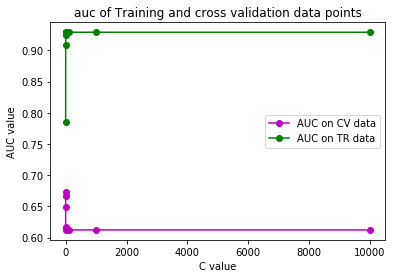

In [44]:
plt.plot([x[0] for x in cv_tup], [x[1] for x in cv_tup], linestyle='-', color='m', marker='o',label='AUC on CV data')
plt.plot([x[0] for x in tr_tup], [x[1] for x in tr_tup], linestyle='-', color='g', marker='o', label='AUC on TR data')
#plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("C value")
plt.ylabel('AUC value')
plt.title('auc of Training and cross validation data points')
plt.legend()

***optimal LR-TFidf-W2V model for C=0.001***

In [45]:
%%time

lr = LogisticRegression(penalty='l1', C=0.001, class_weight='balanced', random_state=56, n_jobs=-1,max_iter=4, solver='saga')
lr.fit(xtr, ytr)
y_pred_test = lr.predict_proba(xtest)
y_pred = lr.predict(xtest)
fpr_test, tpr_test, thresholds_test= roc_curve(ytest, y_pred_test[:,1])
auc_test = auc(fpr_test, tpr_test)
optimal_weight = lr.coef_
print(auc_test)

0.6674664246598462
CPU times: user 3.81 s, sys: 192 ms, total: 4 s
Wall time: 3.7 s


/home/jalesh_j/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


***confusion matrix on test data***

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


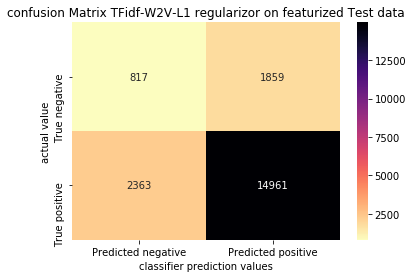

In [46]:
%time
y_pred_test = np.where(y_pred_test[:,1] < 0.5, 0, 1)
#creating confusion matrix:

cf = confusion_matrix(ytest, y_pred_test)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix TFidf-W2V-L1 regularizor on featurized Test data")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

***confusion matrix on training data***

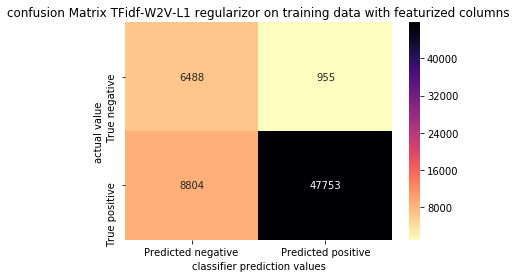

In [47]:
y_pred_tr = np.where(y_pred_tr[:,1] > 0.5, 1, 0)
#creating confusion matrix:

cf = confusion_matrix(ytr, y_pred_tr)
labels = ['True negative', 'True positive']

df_cf = pd.DataFrame(cf, index=labels, columns=['Predicted negative', 'Predicted positive'])
sns.heatmap(df_cf, annot=True,fmt='3d', cmap='magma_r')

plt.title("confusion Matrix TFidf-W2V-L1 regularizor on training data with featurized columns")
plt.xlabel("classifier prediction values")
plt.ylabel("actual value")
plt.show()

***ROC-AUC on train vs test data***

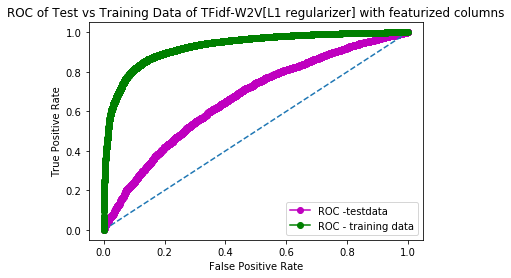

In [48]:
plt.plot(fpr_test, tpr_test, color='m', marker='o',label='ROC -testdata')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_tr, tpr_tr, linestyle='-', color='g', marker='o', label='ROC - training data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Test vs Training Data of TFidf-W2V[L1 regularizer] with featurized columns')
plt.legend()

***we could see that after feature engineering applied we could see the performance of the model is increased by almost 9% from 59 % to 68 %***

***Logistic Regression performance consolidation of 4 vectorizers***

In [49]:
perf_dict = dict(algorithm = ['Bow-L1', 'Tfidf-L1', 'W2V-L1', 'Tfidf-W2V-L1',
                             'Bow-L2', 'Tfidf-L2', 'W2V-L2', 'Tfidf-W2V-L2'],
                C_optimal = [0.01, 0.01, 0.001, 0.001, 0.0001, 0.0001, 0.0001, 0.0001],
                AUC = [0.928, 0.937, 0.730, 0.678, 0.926, 0.929,0.707, 0.698])

perf_df = pd.DataFrame(perf_dict)
perf_df

,AUC,C_optimal,algorithm
0,0.928,0.0100,Bow-L1
1,0.937,0.0100,Tfidf-L1
2,0.730,0.0010,W2V-L1
3,0.678,0.0010,Tfidf-W2V-L1
4,0.926,0.0001,Bow-L2
5,0.929,0.0001,Tfidf-L2
6,0.707,0.0001,W2V-L2
7,0.698,0.0001,Tfidf-W2V-L2


***Conclusions -- out of 1L datapoints:***

1. TFidf with L1 performed best on unseen test data point with 93% AUC score.
2. TFidf-w2v with L1 performed least on unseen test datapoints with 67% AUC score.
3. perturbation test was performed on BoW with L1 and it was observed multicollinearity amongst features.
4. feature engineering was performed on W2V and TFidf-W2V with L1 regularizer
5. with feature engineered column, we observed dip in model performance of TFidf-w2v(L1) by 2 % (AUC ~ 67%)
6. with feature engineered column, we observed slightly increase in model performance of Avg-W2V by 2 % (AUC ~ 75)